<center><font size=6> Bank Churn Prediction </font></center>

## Problem Statement

### Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
    * 0=No ( Customer did not leave the bank )
    * 1=Yes ( Customer left the bank )

## Importing necessary libraries

In [68]:
import os
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from keras import backend
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Initialization

In [2]:
rn=42
early_stopping = EarlyStopping(
    monitor='recall',
    mode = 'max',
    patience=25,
    verbose=1,
    restore_best_weights=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
random.seed(rn)
np.random.seed(rn)
tf.random.set_seed(rn)
keras.utils.set_random_seed(rn)
tf.config.experimental.enable_op_determinism()
tf.get_logger().setLevel('ERROR')

In [3]:
sns.set(style='darkgrid', context='poster', palette='muted')

In [4]:
%%html
<style>
    .custom_header1 {
        font-size: 160%;
        color: midnightblue;
        font-family: calibri;
        font-weight: bold;
        text-align:left;
        padding-bottom: 0px;
    }    
    .custom_header2 {
        font-size: 130%;
        color: green;
        font-family: calibri;
        text-align:left;
        padding-bottom: 0px;
        text-decoration: underline;
    }
    .observation_text {
        font-size: 130%;
        color: gray;
        font-family: calibri;
        text-align:left;
        padding-bottom: 0px;
        text-decoration: underline;
    }
</style>

## Loading the dataset

In [5]:
data= pd.read_csv("../data/churn.csv")
df= data.copy()

## Data Overview

In [6]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


In [7]:
data_shape= data.shape
print("no of rows:",data_shape[0])
print("no of columns:",data_shape[1])

no of rows: 10000
no of columns: 14


We can observe that the row number is the same as the index + 1, and the customer ID is another unique identifier. Since these columns do not provide much value for our analysis, we will drop both.

In [8]:
df.drop(['RowNumber','CustomerId'],axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


<div class="observation_text">Observations:</div>

1. We have 10000 rows in our dataset.
2. 7 features are of integer type, 2 featurees are float type and 3 features are object type.

In [10]:
df.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<div class="observation_text">Observations:</div>

We do not have any features with missing data.

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [12]:
df.describe(include=['object']).T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


<div class="observation_text">Observations:</div>

1. Credit Score: The mean and median are close, suggesting the data might be symmetric with little skew. The values span widely, and we might have some outliers in the left side as (584-350)>(850-718).
2. Age: The mean is slightly greater than the median, possibly indicating a slight positive skew. The difference between the 75th percentile and the maximum also suggests some outliers.
3. Tenure: The mean and median are very close, so we can expect symmetry. The minimum value is 0, and the maximum is 10.
4. Balance: The mean (76485.89) is less than the median (97198.54), suggesting a left-skewed distribution. Both the minimum and the 25th percentile are zero, indicating that many accounts have zero balance.
5. NumOfProducts: They are categorical in nature and minimum number of product is 0 where maximum number of product is 4.
6. HasCrCard: A value of 1 indicates customers who have/had a credit card, while 0 indicates those who do not/did not. It is evident that more customers have credit cards than those who do not.
7. IsActiveMember: This is a categorical variable that determines whether a customer is an active bank member. The mean is 0.515, the median is 1, and the standard deviation is 0.5. This indicates a balanced distribution, split between 0 and 1.
8. EstimatedSalary: The mean (100090.24) and the median (100193.92) are very close, indicating a symmetrical distribution. Also, $(51002.11 - 11.58) \approx (100193.915 - 51002.11) \approx (149388.2475 - 100193.915) \approx (199992.48 - 149388.2475) \approx 5000$, showing the data could be uniformly distributed.
9. Exited: Our target feature, Exited, shows highly imbalanced data where class 0 dominates.
10. Surname: There are 2932 unique surnames, with “Smith” being the most common. Since the number of unique surnames is significant, we can consider dropping this column.
11. Geography: The bank provides services in only three locations, with most customers being from France
12. Gender: Of the two genders, the number of male customers is slightly higher than that of female customers.

<div class="custom_header2">Action From Above Analysis:</div>

In [13]:
df.drop(['Surname'],axis=1,inplace=True)

In [14]:
numeric_columns=['CreditScore','Age','Tenure','Balance','EstimatedSalary']
categorical_columns=['Geography','Gender','NumOfProducts']
binary_categorical_columns=['HasCrCard','IsActiveMember']
target_feature=['Exited']

In [15]:
df.duplicated().sum()

0

<div class="observation_text">Observations:</div>

There is no duplicate rows present.

## Exploratory Data Analysis

The following functions will help in Exploratory Data Analysis (EDA). Instead of repeatedly writing the same commands, we will call these four functions for our EDA process.

<div class="custom_header1">Functions for Univariate Analysis</div>

In [16]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [17]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--", label="Mean"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-", label="Median"
    )  # Add median to the histogram
    ax_hist2.legend(loc="upper right")

<div class="custom_header1">Functions for bivariate analysis</div>

In [18]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [19]:
# Function to plot distributions
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of " + str(predictor)+ " for: " + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of " + str(predictor)+ " for: " + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t "+str(target))
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0],color="teal")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t "+str(target))
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        color="orange"
    )

    plt.tight_layout()
    plt.show()

<div class="custom_header2">Univariate Analysis</div>

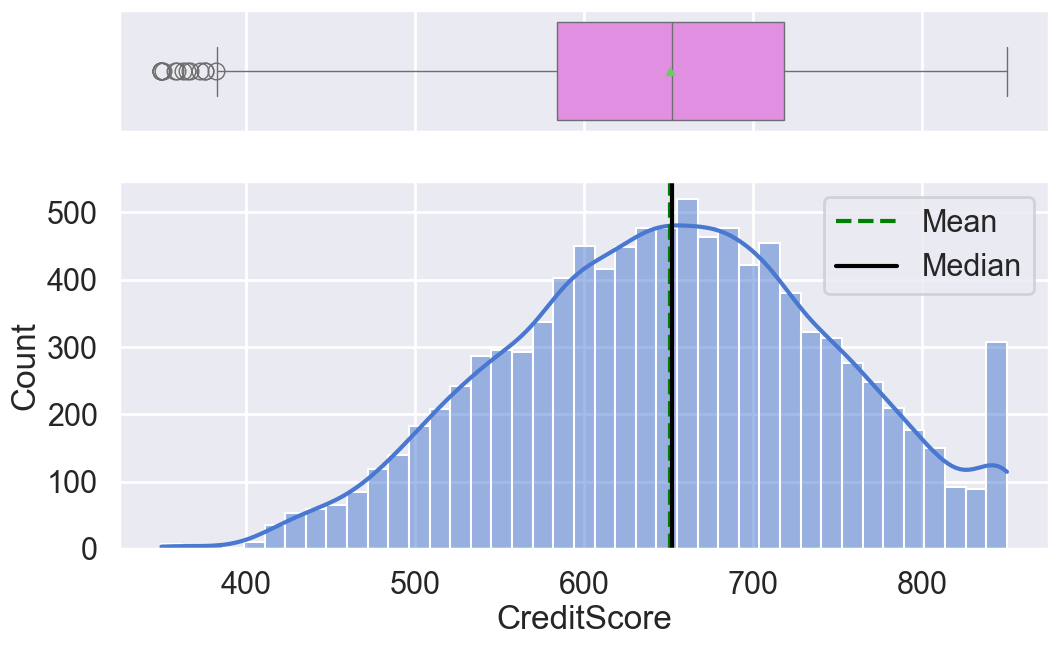

In [20]:
histogram_boxplot(df, "CreditScore", kde=True)

<div class="observation_text">Observations:</div>

1. We can observe some outliers on the left side, which means very low credit scores are present for only a few customers.
2. Mean and median values are almost same. Which can be also seen in the partial symmetry of the distrbution.
3. More than 300 customers have very high credit score (more than 800).

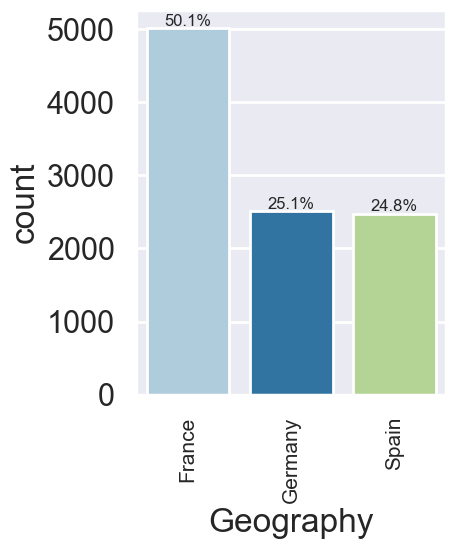

In [21]:
labeled_barplot(df, "Geography", perc=True)

<div class="observation_text">Observations:</div>

More than 50% of customers are from France, while the other two regions have almost the same number of customers, with Germany having slightly more (25.1%) than Spain (24.8%).

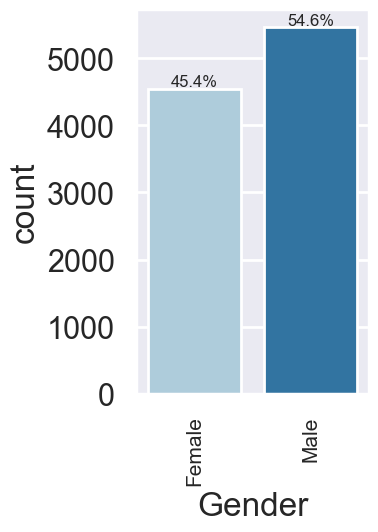

In [22]:
labeled_barplot(df, "Gender", perc=True)

<div class="observation_text">Observations:</div>

54.6% customers are male and 45.4% customers are female.

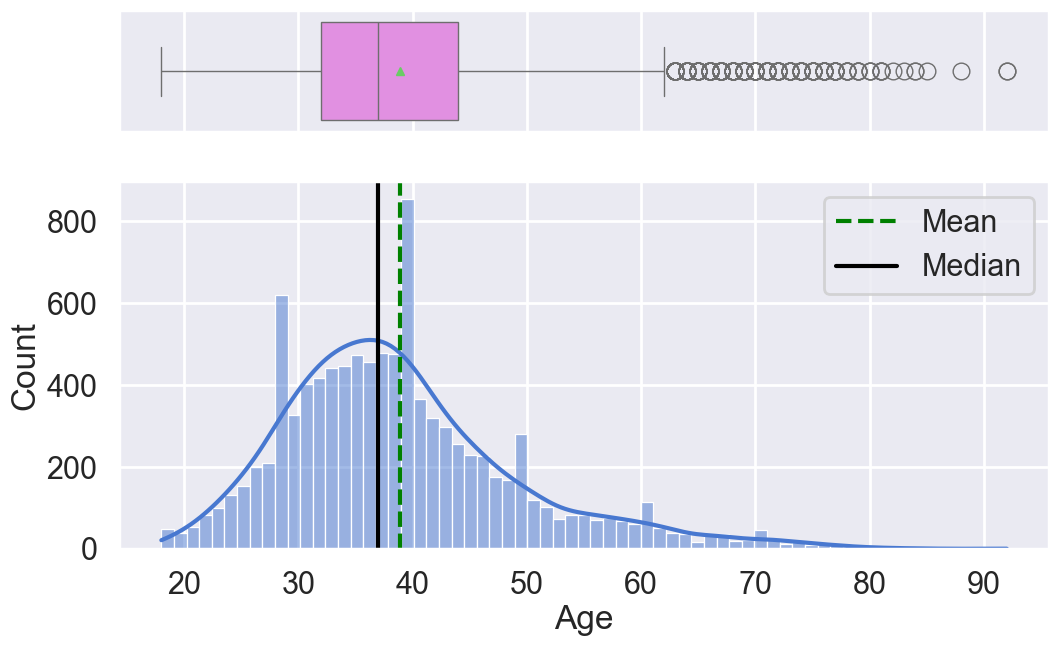

In [23]:
histogram_boxplot(df, "Age", kde=True)

<div class="observation_text">Observations:</div>

1. Older customers are outliers, causing the mean to be higher than the median.
2. The distribution is right-skewed due to these outliers.

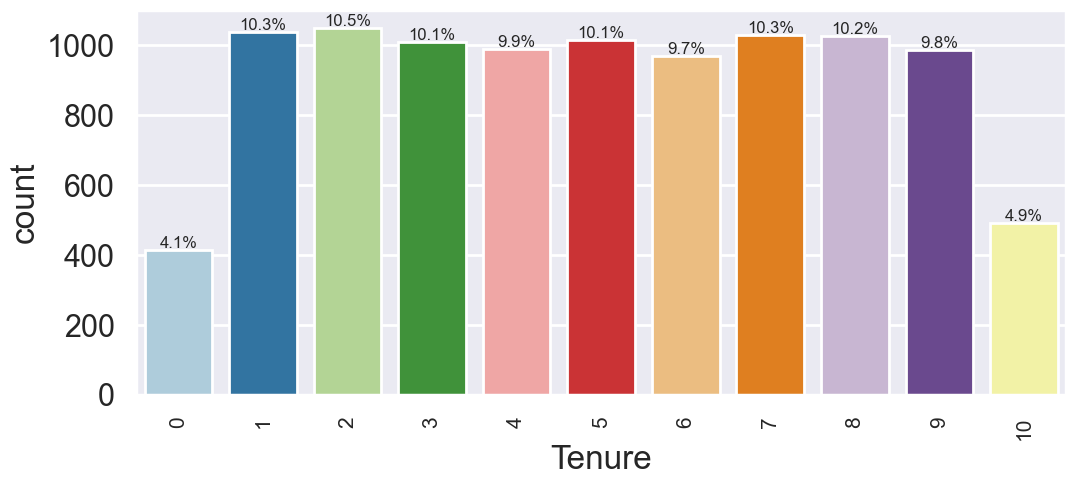

In [24]:
labeled_barplot(df, "Tenure", perc=True)

<div class="observation_text">Observations:</div>

1. We can observe that customers with the lowest and highest tenures are the fewest in number.
2. Customers with tenures between 1 and 9 are uniformly distributed, which shows the bank has a fairly even distribution of customers within this range.

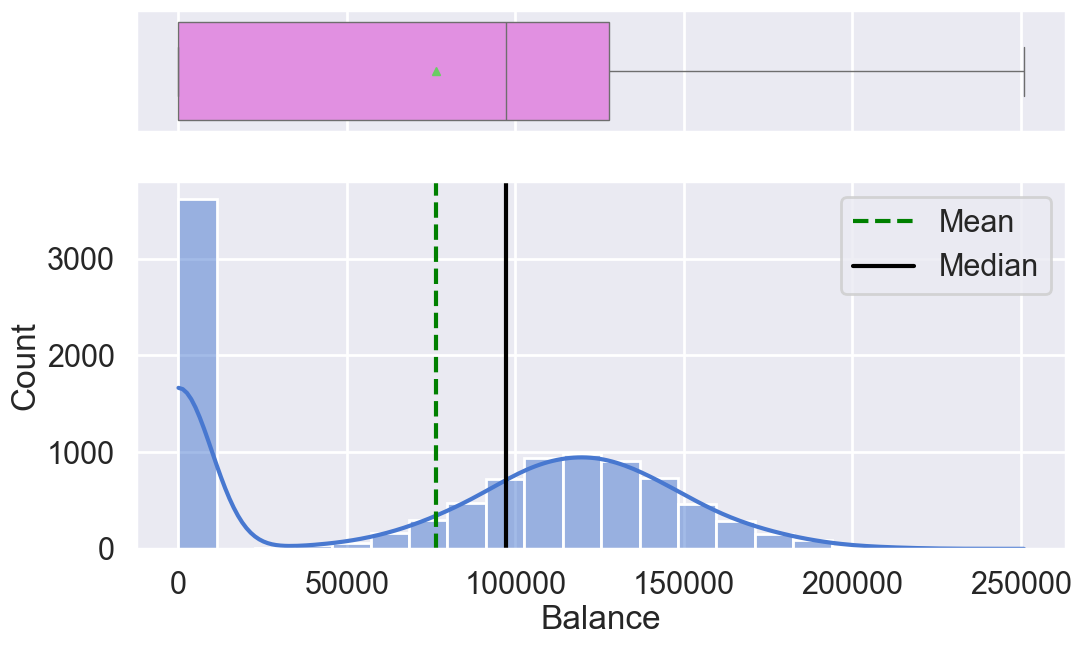

In [25]:
histogram_boxplot(df, "Balance", kde=True)

<div class="observation_text">Observations:</div>

1. Most of the customers has zero account balance.
2. There is no outliers.
3. Long whisker on the right side and median>mean shows bimodal distribution.
4. Few customers has big account balance as large as 250000.

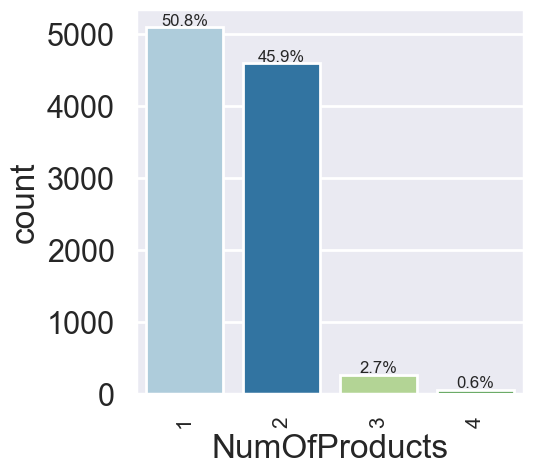

In [26]:
labeled_barplot(df, "NumOfProducts", perc=True)

<div class="observation_text">Observations:</div>

1. Most of the customers had purchased only 1 to 2 products from the banks.
2. only 3.3% customers bought more than 2 products from the bank.

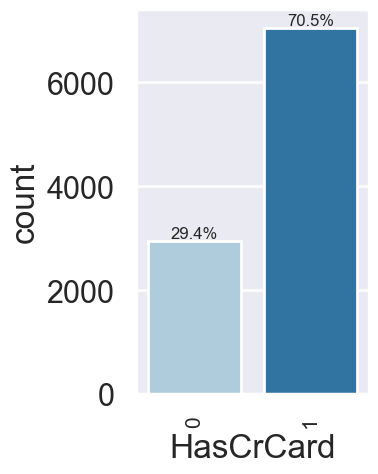

In [27]:
labeled_barplot(df, "HasCrCard", perc=True)

<div class="observation_text">Observations:</div>

We can observe more than 70% customer has credit card.

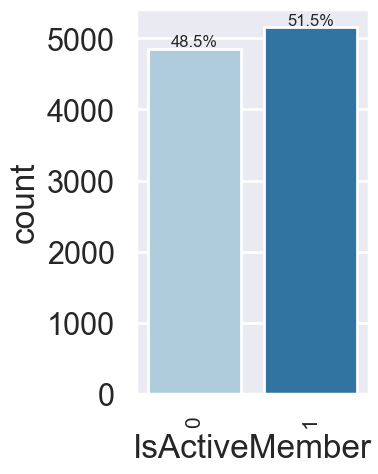

In [28]:
labeled_barplot(df, "IsActiveMember", perc=True)

<div class="observation_text">Observations:</div>

More than 51% customers are active where 48.5% customers are not active.

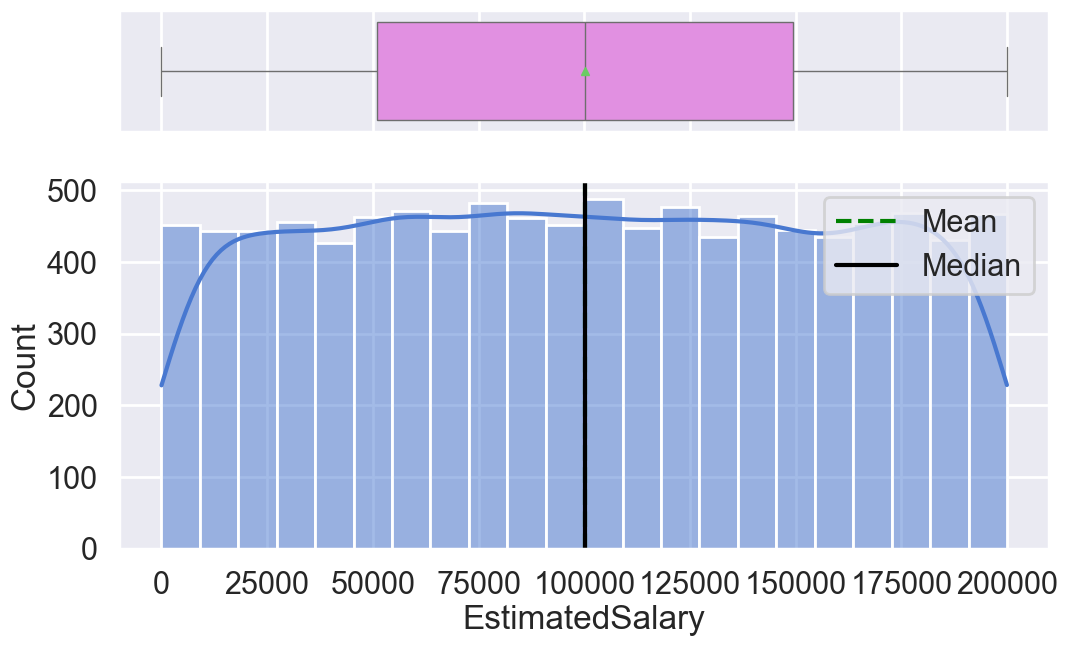

In [29]:
histogram_boxplot(df, "EstimatedSalary", kde=True)

<div class="observation_text">Observations:</div>

1. There is no outliers in Estimated salary distribution.
2. The distribution looks uniform where the salary could be as high as 200000.

<div class="custom_header2">Heatmap Analysis</div>

In [30]:
numeric_cols= df.select_dtypes(exclude=['object']).columns
corr_matrix=df[numeric_cols].corr()

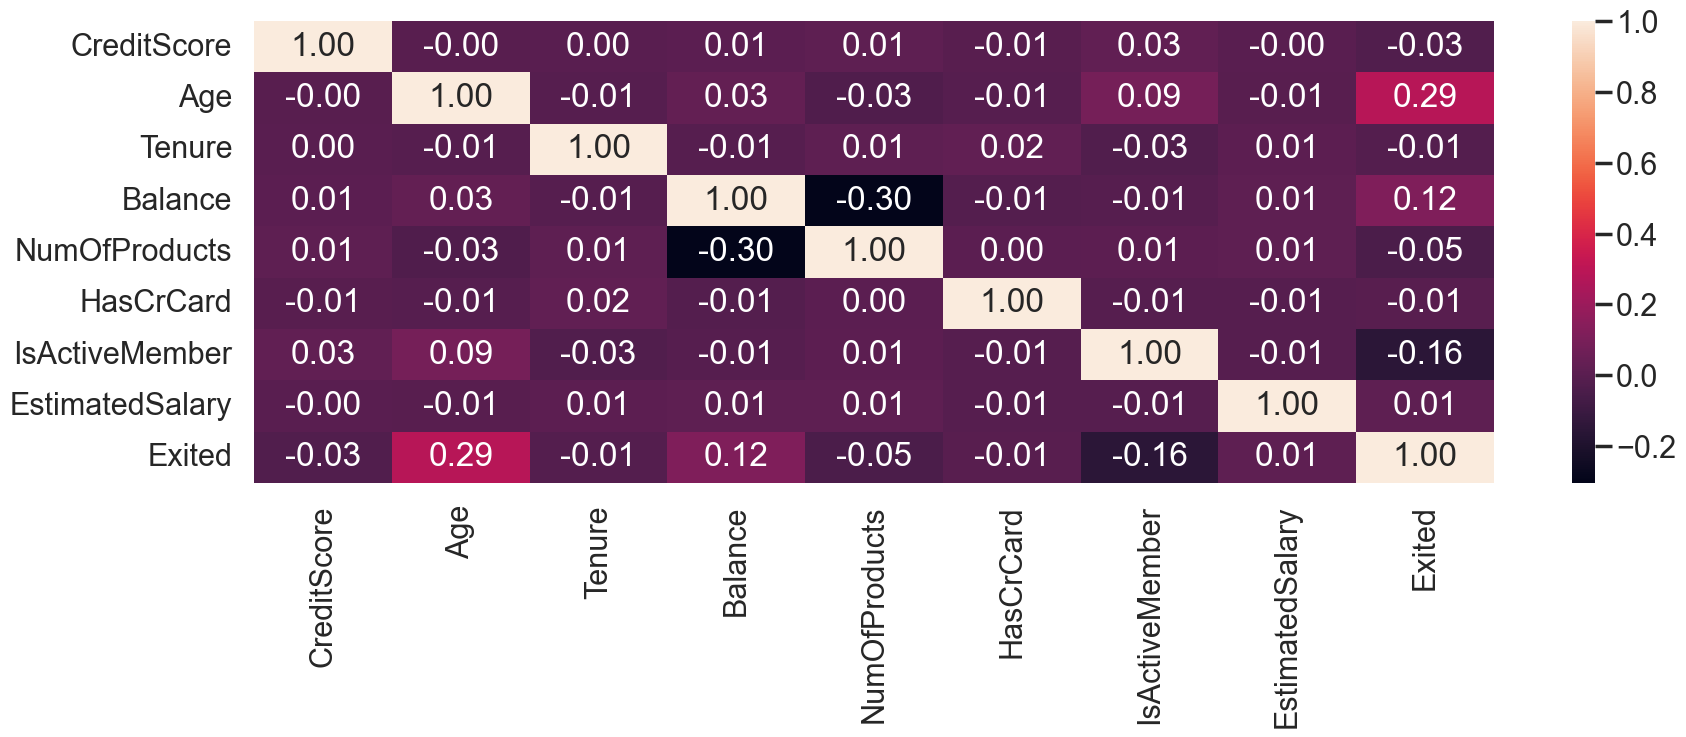

In [31]:
plt.figure(figsize=(20,6))
sns.heatmap(corr_matrix,annot=True,fmt=".2f")
plt.show()

<div class="observation_text">Observations:</div>

1. We do not observe any strong correlation between the features.
2. NumberOfProducts and Balance have the highest negative correlation of -0.30, which might indicate that customers with more products tend to have lower account balances.
3. Age has a positive correlation of 0.29 with the target variable Exited. This suggests that older customers may have a higher chance of churning, but since the correlation is not very strong, further analysis is needed to confirm this.

<div class="custom_header2">Bivariate Analysis</div>

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


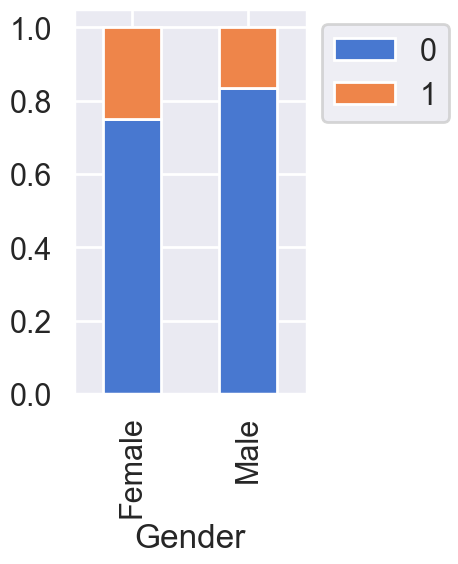

In [32]:
stacked_barplot(df, 'Gender', 'Exited')

<div class="observation_text">Observations:</div>

Female customers have exited more than male customers. We need to investigate further to understand why this is happening.

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


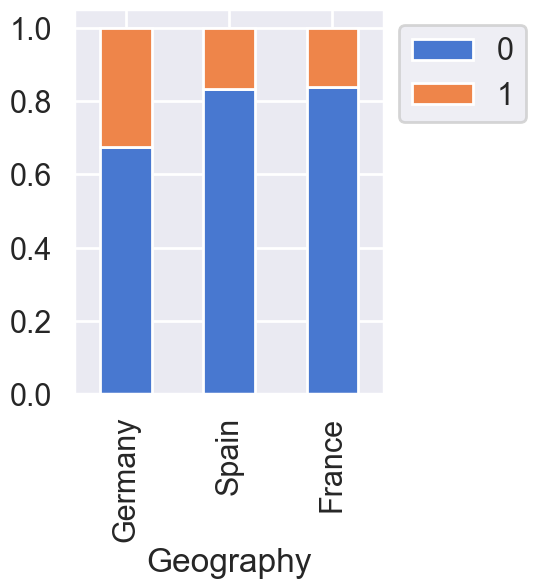

In [33]:
stacked_barplot(df, 'Geography', 'Exited')

<div class="observation_text">Observations:</div>

Both in total numbers and ratio, most customer churn is from Germany. France and Spain have similar churn ratios, with France having the lowest. We need to investigate what might be causing higher churn in the Germany branch.

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


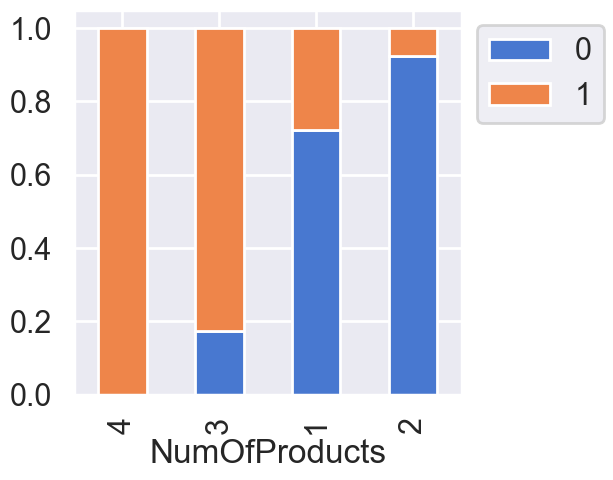

In [34]:
stacked_barplot(df, 'NumOfProducts', 'Exited')

<div class="observation_text">Observations:</div>

We can clearly see that customers who took 4 products from the bank always churned, and churn is significantly higher among customers who took 3 products. Customers with 2 products are least likely to churn. We should focus on limiting customers to 2 products and consider offering only 2 products to reduce churn.

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


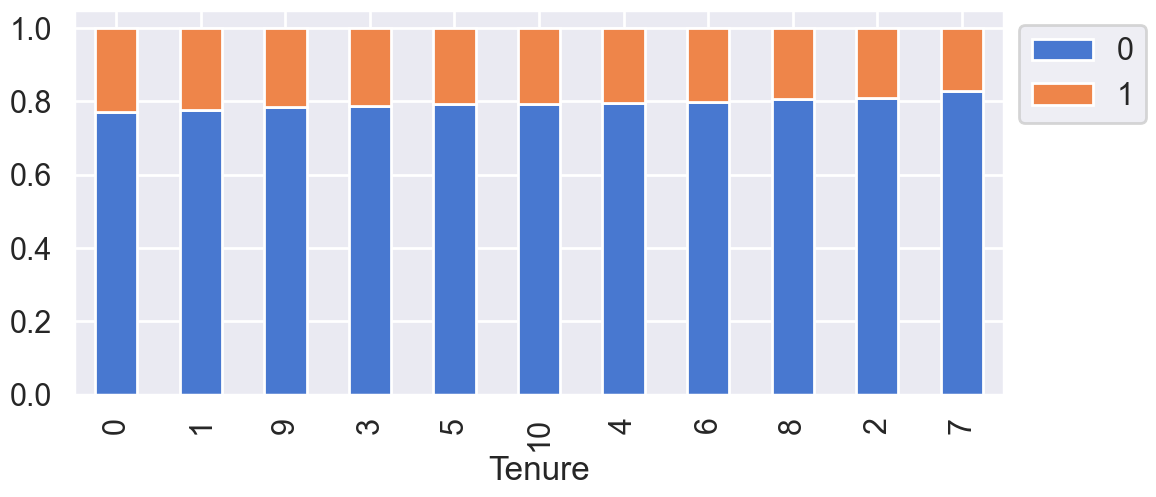

In [35]:
stacked_barplot(df, 'Tenure', 'Exited')

<div class="observation_text">Observations:</div>

Customers who are new to the bank (0 to 1 year) are most likely to churn, although the pattern is not very strong.

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


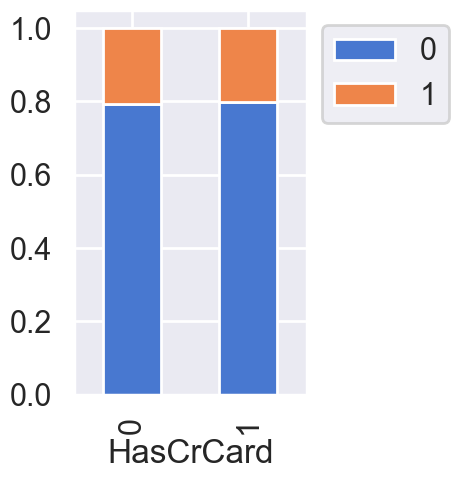

In [36]:
stacked_barplot(df, 'HasCrCard', 'Exited')

<div class="observation_text">Observations:</div>

There is no clear pattern, so having a card or not alone will not help in predicting churn.

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


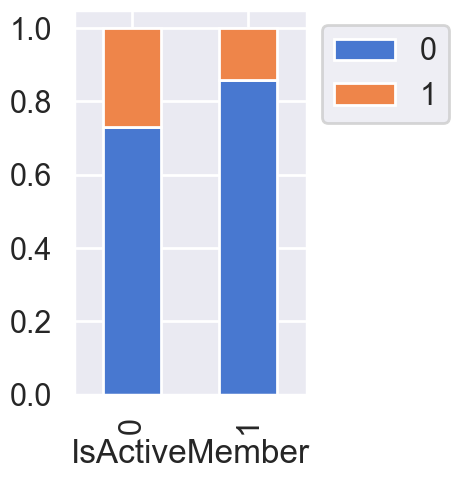

In [37]:
stacked_barplot(df, 'IsActiveMember', 'Exited')

<div class="observation_text">Observations:</div>

Customers who were more active were less likely to churn.

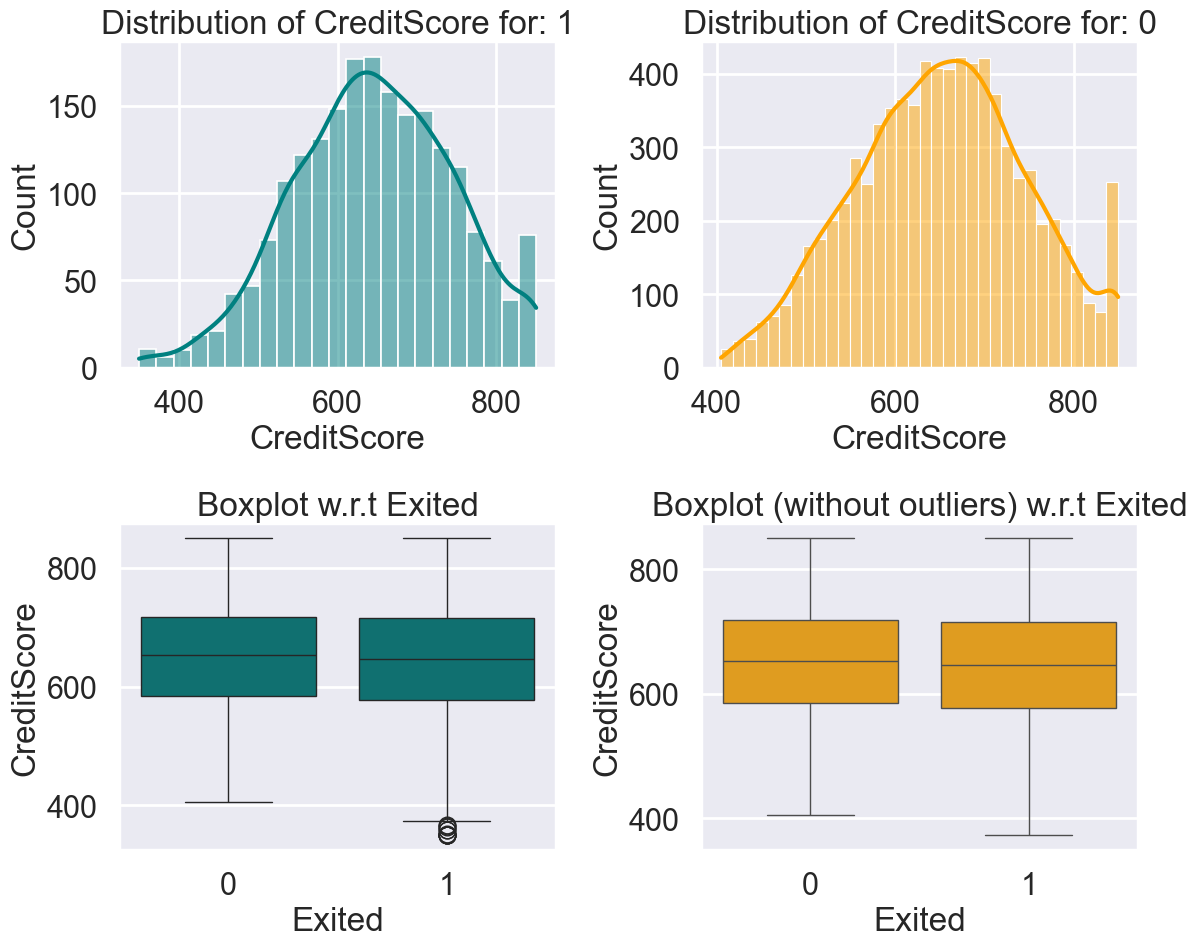

In [38]:
distribution_plot_wrt_target(df, 'CreditScore', 'Exited')

<div class="observation_text">Observations:</div>

1. We can observe the distribution is very similar for both who exited and who remained as customer.
2. We can also observe the customers remained in the bank do not have credit score below 400, all of them exited.

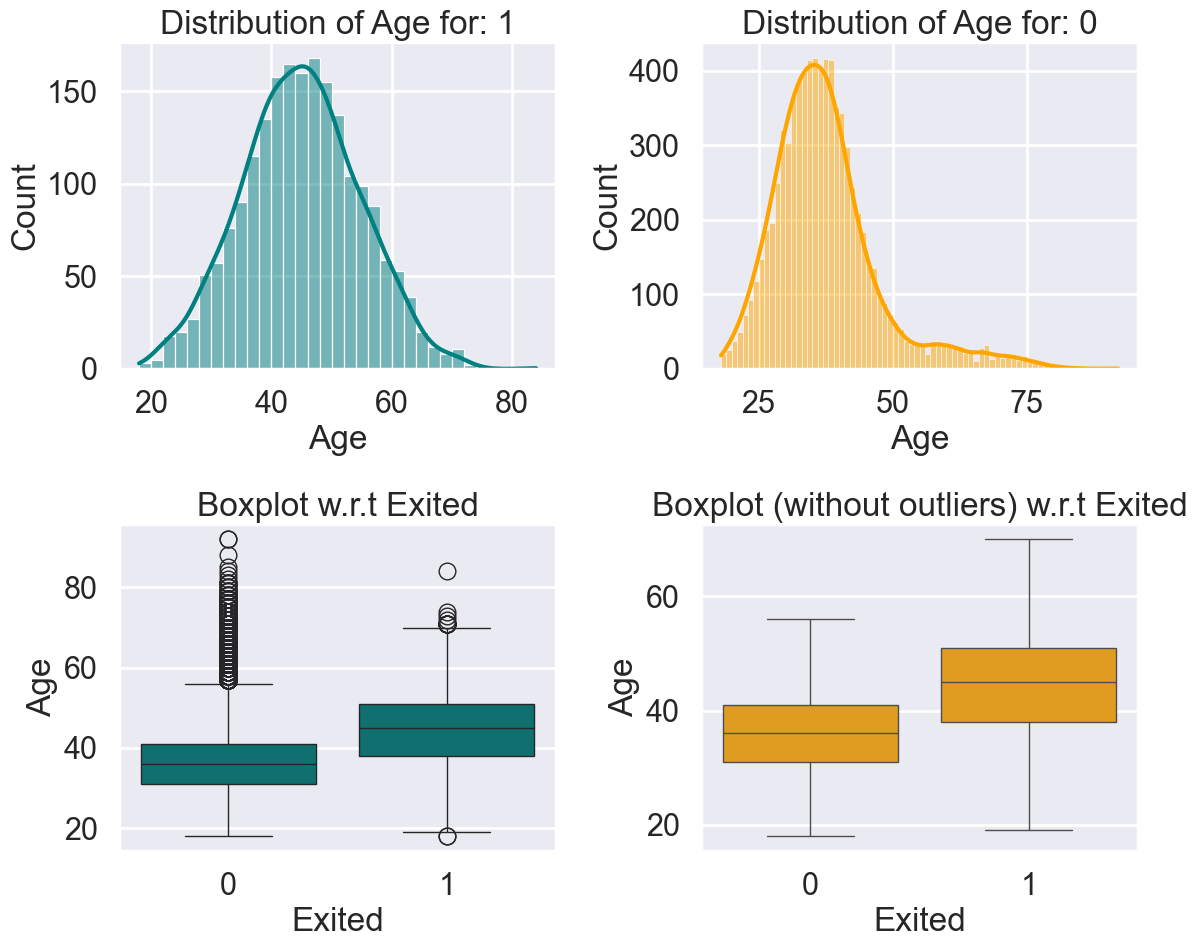

In [39]:
distribution_plot_wrt_target(df, 'Age', 'Exited')

<div class="observation_text">Observations:</div>

1. We can observe the chances of churning is much more for aged customer.
2. The distribution for churning with age is symmetrical withs lightly skewed in the right. which says the older the customer the chances or churning is little higher.

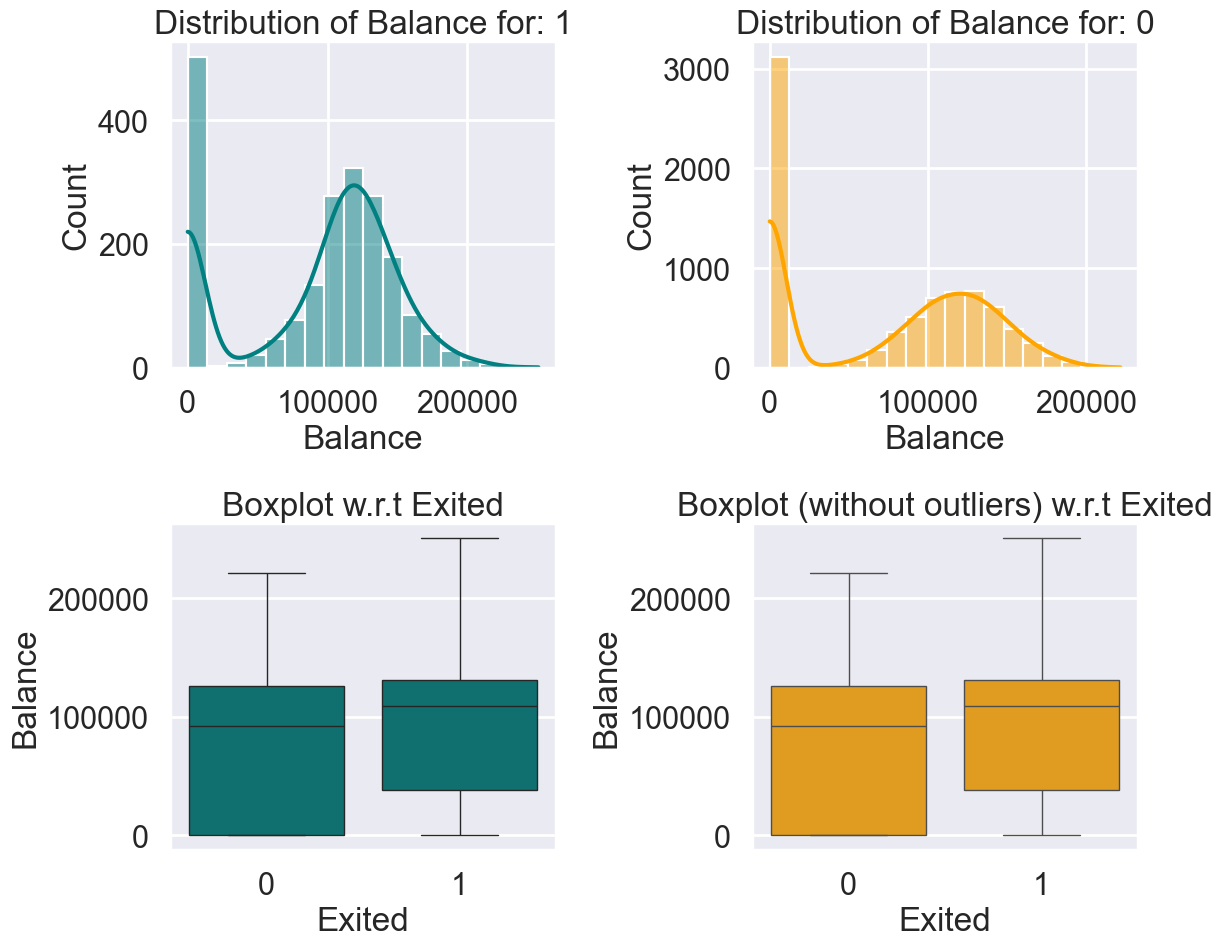

In [40]:
distribution_plot_wrt_target(df, 'Balance', 'Exited')

<div class="observation_text">Observations:</div>

Customers who churned are more likely to have a higher balance than those who did not, which is not a good indication. We need to consider strategies to retain customers with high balances.

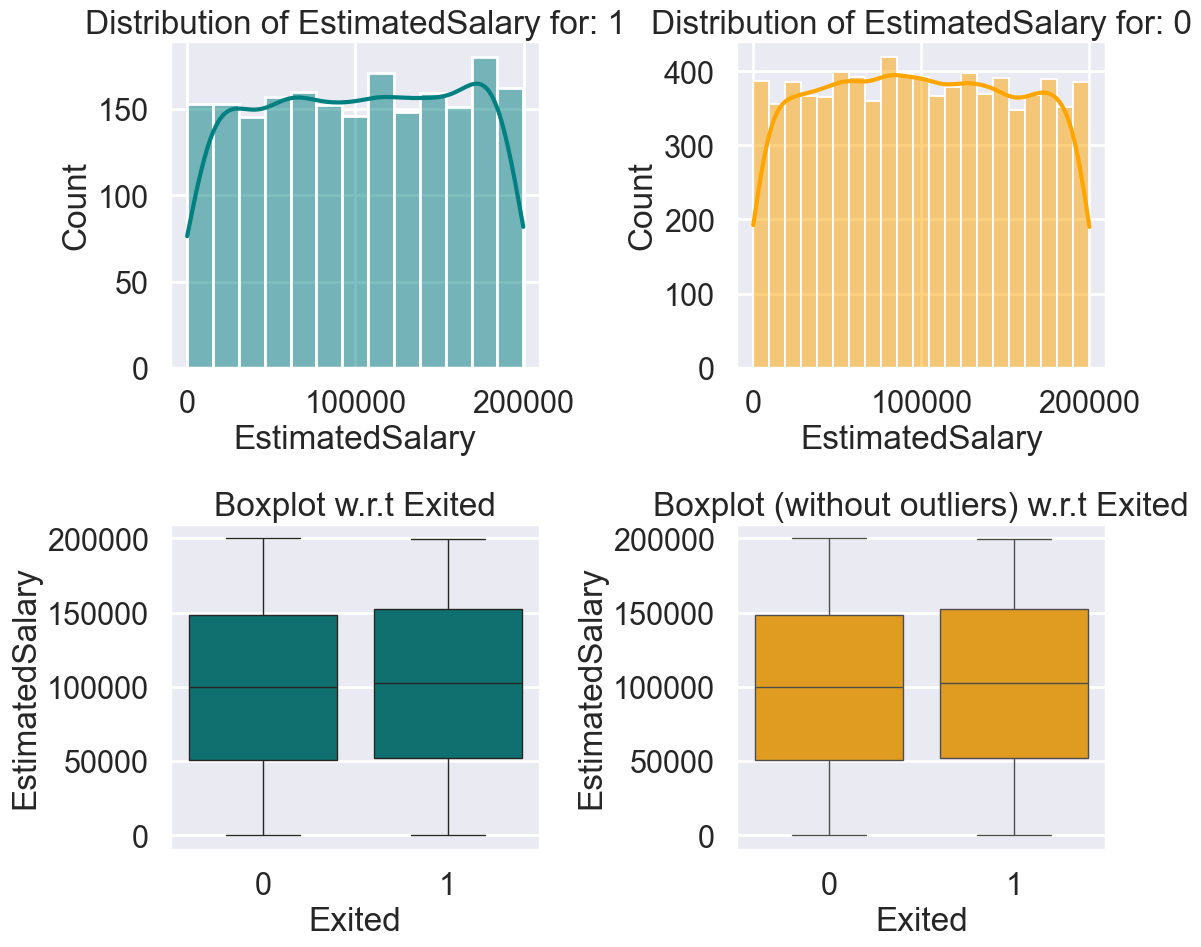

In [41]:
distribution_plot_wrt_target(df, 'EstimatedSalary', 'Exited')

<div class="observation_text">Observations:</div>

It seems that estimated salary alone does not influence customer churn.

Now that we have a clear understanding of our model, let’s start preprocessing the existing features so that we can build the model.

## Data Preprocessing

### Dummy Variable Creation

In [42]:
df=pd.get_dummies(df,columns=categorical_columns,drop_first=True)
df.sample(5)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
6366,683,73,9,124730.26,1,1,51999.50,0,True,False,True,False,False,False
9628,662,22,9,0.00,1,1,44377.65,0,False,False,False,True,False,False
5916,633,39,2,0.00,0,0,191207.03,0,False,True,False,True,False,False
681,591,58,5,128468.69,0,1,137254.55,0,False,True,True,False,False,False
5459,530,36,7,0.00,1,0,80619.09,0,False,True,False,True,False,False


### Train-validation-test Split

In [43]:
X=df.drop(['Exited'],axis=1)
y=df['Exited']

X_train,X_temp,y_train,y_temp=train_test_split(X,y,train_size=.7,stratify=y,random_state=rn)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=.5,stratify=y_temp,random_state=rn)

In [44]:
print("Total Datapoints:",df.shape[0],"\nTraining Set Data-points:",y_train.shape[0],"\nValidation Set Data-points:",y_val.shape[0],"\nTest Set Data-points:",y_test.shape[0])
print("-"*120)
print("Before Splitting the target variable distribution is:",df['Exited'].value_counts(1),sep="\n")
print("After Splitting the distribution of target variable in training set is:",y_train.value_counts(1),sep="\n")
print("After Splitting the distribution of target variable in validation set is:",y_val.value_counts(1),sep="\n")
print("After Splitting the distribution of target variable in test set is:",y_test.value_counts(1),sep="\n")

Total Datapoints: 10000 
Training Set Data-points: 7000 
Validation Set Data-points: 1500 
Test Set Data-points: 1500
------------------------------------------------------------------------------------------------------------------------
Before Splitting the target variable distribution is:
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64
After Splitting the distribution of target variable in training set is:
Exited
0    0.796286
1    0.203714
Name: proportion, dtype: float64
After Splitting the distribution of target variable in validation set is:
Exited
0    0.796
1    0.204
Name: proportion, dtype: float64
After Splitting the distribution of target variable in test set is:
Exited
0    0.796667
1    0.203333
Name: proportion, dtype: float64


<div class="observation_text">Observations:</div>

1. We can observe the ratio in all the training, validation and test set are almost same i.e. 80:20. In all the set approx. 80% of the customers did not churn and approx. 20% customers churned.

In [45]:
X.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,619,42,2,0.00,1,1,101348.88,False,False,False,False,False,False
1,608,41,1,83807.86,0,1,112542.58,False,True,False,False,False,False
2,502,42,8,159660.80,1,0,113931.57,False,False,False,False,True,False
3,699,39,1,0.00,0,0,93826.63,False,False,False,True,False,False
4,850,43,2,125510.82,1,1,79084.10,False,True,False,False,False,False


### Data Normalization

In [46]:
print("X_train before standardization:")
X_train.head()

X_train before standardization:


,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
9136,595,20,4,95830.43,1,0,177738.98,False,False,True,False,False,False
6410,689,63,1,0.00,1,1,186526.12,False,True,False,True,False,False
2607,814,31,1,118870.92,1,0,101704.19,False,False,True,False,False,False
3201,722,20,6,0.00,1,0,195486.28,False,False,True,True,False,False
3330,738,18,4,0.00,1,1,47799.15,False,False,True,True,False,False


In [47]:
columns_to_standardize=["CreditScore","Age","Tenure","Balance","EstimatedSalary"]
scaler=StandardScaler()
scaler.fit(X_train[columns_to_standardize])

StandardScaler()

In [48]:
X_train[columns_to_standardize] = scaler.transform(X_train[columns_to_standardize])
X_val[columns_to_standardize] = scaler.transform(X_val[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

In [49]:
print("X_train after standardization:")
X_train.head()

X_train after standardization:


,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
9136,-0.575582,-1.796679,-0.349474,0.312906,1,0,1.362512,False,False,True,False,False,False
6410,0.398182,2.269825,-1.386929,-1.223574,1,1,1.515472,False,True,False,True,False,False
2607,1.693082,-0.756410,-1.386929,0.682321,1,0,0.038955,False,False,True,False,False,False
3201,0.740036,-1.796679,0.342162,-1.223574,1,0,1.671444,False,False,True,True,False,False
3330,0.905783,-1.985818,-0.349474,-1.223574,1,1,-0.899384,False,False,True,True,False,False


Let’s also take a look at a few samples from the X_test and X_validation datasets after preprocessing:

In [50]:
X_test.sample(3)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
4207,0.056329,-0.188991,0.687981,0.576829,1,0,0.934624,False,False,True,False,False,False
4333,0.760754,-0.472701,0.342162,0.672137,0,0,1.003892,True,False,True,True,False,False
4701,0.014892,-1.134690,1.725435,0.496861,0,0,-0.957931,False,False,True,True,False,False


In [51]:
X_val.sample(3)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
9036,1.216559,-0.283561,-0.695292,1.042494,0,1,0.459624,False,False,False,False,False,False
3148,-0.026545,0.000149,0.342162,0.871899,1,1,0.948505,False,False,False,True,False,False
2518,1.112967,1.040417,-1.041110,0.312638,1,1,-0.548715,False,False,False,False,True,False


<div class="custom_header2">Handle Imbalanced Data:</div>

Earlier, we identified that our dataset is imbalanced. To handle that, we already split our training, testing, and validation data in such a way that all datasets have the same class ratio.
<br>Now:<br>
1.	We will calculate the ratio of these classes so that when building the model, we can adjust for class imbalance, ensuring no class gets extra importance and we get better generalized results.<br>
2.	Later, we will create synthetic data using SMOTE to balance the dataset and observe if that improves our model’s performance.<br>

Now, let’s start by calculating class weights for the imbalanced dataset.

In [52]:
cw = (y_train.shape[0]) / np.bincount(y_train.astype(int))

cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: 1.2558306422676713, 1: 4.908835904628331}

In [53]:
# defining the batch size and # epochs upfront as we'll be using the same values for all models
epochs = 25
batch_size = 64
input_features = X_train.shape[1]

### Utility functions

Utility functions for visualizing loss and model's performance: one plots the history of training and validation loss, while the other displays key performance metrics such as accuracy, recall, precision, and F1 score.

In [54]:
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(history.history[name], label='Train')
    ax.plot(history.history['val_' + name], label='Validation')
    ax.set_title('Model ' + name.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name.capitalize())
    ax.legend(bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [55]:
def model_performance_classification(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) > threshold

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},
        index=[0],
    )

    return df_perf

## Model Building

### Model Evaluation Criterion

**A model can make wrong predictions in the following ways:**
- Predicting that a customer will churn when they are not planning to churn.
- Predicting that a customer will not churn when they have already started showing signs of churn.

**Importance of both Predictions:**
In the two cases mentioned above, there are costs associated with the wrong predictions. We need to determine which cost the bank is willing to bear.
- If the model does not focus on reducing false positives, customers who will not churn might also be predicted as likely to churn. In this case, the bank might give them extra attention or offer special deals, even though these offers are unnecessary since the customer would not churn anyway. This leads to additional costs for no reason.
- If the model does not focus on reducing false negatives, customers who will churn might not be predicted as such. As a result, they may not receive special offers and may end up churning within 6 months.

Both cases are important. However, for our case, the bank wants to know whether a customer will churn or not in the next 6 months. So, predicting customers who will churn is more important. Even if we mistakenly predict a non-churner as a potential churner, it allows the bank to take proactive measures. Therefore, **recall** is more important in this case, and we will use recall as our metric.


In [56]:
metrics=[tf.keras.metrics.Recall()]

<div class="custom_header2">Reusable Model Building Code:</div>

In [57]:
def print_model_info(model):
    print("MODEL INFO:")
    print("*" * 30)
    print(f"Model optimizer: {model.optimizer}")
    print(f"Loss function: {model.loss}")
    for layer in model.layers:
        print("-" * 30)
        print(f"Layer: {layer.name}")
        if hasattr(layer, 'activation'):
            print(f"Activation: {layer.activation.__name__}")

In [58]:
def create_model(v_optimizer='adam',v_hidden_layer=[14], v_activation=['relu'], drop_out=[0]):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    if len(v_hidden_layer) != len(v_activation):
        print('number of hidden layers and number of activation functions should be equal')
        return
        
    if len(v_hidden_layer) != len(drop_out):
        print('number of hidden layers and number of drop out should be equal; use 0 when no dropout is required for a layer')
        return

        
    #hidden layer logic
    for i,activation in enumerate(v_activation):
        if(i==0):
            model.add(Dense(v_hidden_layer[i], activation=activation, input_dim=input_features))
        else:
            model.add(Dense(v_hidden_layer[i], activation=activation))
        if drop_out[i] > 0:
            model.add(Dropout(drop_out[i]))

    
    #model.add(Dense(1,activation="sigmoid", kernel_initializer='glorot_uniform')) #output layer
    model.add(Dense(1,activation="sigmoid")) #output layer
    model.summary()

    model.compile(optimizer=v_optimizer, loss='binary_crossentropy', metrics=metrics)
    print("-" * 30)
    print_model_info(model)
    return model

### Neural Network with SGD Optimizer

- Let's start with a neural network consisting of
  - one hidden layer with 16 neurons.
  - ReLU as activation function.
  - SGD as the optimizer.

In [59]:
model=create_model(v_optimizer='sgd',v_hidden_layer=[16], v_activation=['relu'], drop_out=[0])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.sgd.SGD object at 0x31f35e080>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: relu
------------------------------
Layer: dense_1
Activation: sigmoid


In [60]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], class_weight=cw_dict, shuffle=False)
end=time.time()

Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.6548 - recall: 0.4626 - val_loss: 0.6228 - val_recall: 0.5752
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2301 - recall: 0.6361 - val_loss: 0.5496 - val_recall: 0.6895
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1468 - recall: 0.6813 - val_loss: 0.5260 - val_recall: 0.7288
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1167 - recall: 0.6945 - val_loss: 0.5143 - val_recall: 0.7418
Epoch 5/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0997 - recall: 0.7030 - val_loss: 0.5073 - val_recall: 0.7516
Epoch 6/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0885 - recall: 0.7091 - val_loss: 0.5021 - val_recall: 0.7582
Epoch 7/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0806 - recall: 0.7142 - val_loss: 0.4990 - val_recall: 0.7647
Epoch 8/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0751 - recall: 0.7230 - val_loss: 0.4982 - val_recall: 0.7745


In [61]:
print("Time taken in seconds ",end-start)

Time taken in seconds  44.20311498641968


In [62]:
# Check the which epoch our model chose as the best available model
best_epoch = np.argmax(history.history['recall']) + 1  # Since epochs are 1-indexed
best_recall = max(history.history['recall'])
print(f"The best epoch was: {best_epoch} and best recall was: {best_recall}")

The best epoch was: 18 and best recall was: 0.7482468485832214


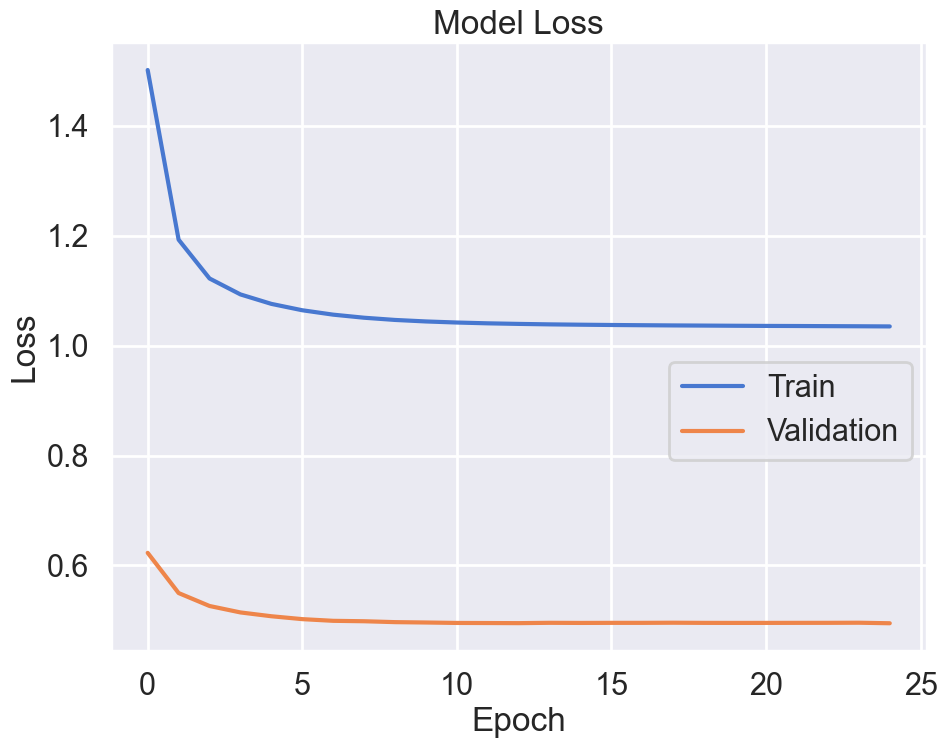

In [63]:
plot(history,'loss')

In [64]:
model_1_train_perf = model_performance_classification(model, X_train, y_train)
model_1_train_perf

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.747286,0.747286,0.821155,0.768198


In [65]:
model_1_valid_perf = model_performance_classification(model, X_val, y_val)
model_1_valid_perf

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.760667,0.760667,0.83807,0.780966


<div class="observation_text">Observations:</div>

- Training Loss:
    - Starts high (approx. 1.5) and drops quickly during the first few epochs.
    - Then stabilizes around 1.05 loss and does not improve further.
- Validation Loss:
    - Starts much lower (approx. 0.6) and stabilizes around 0.5.
    - The validation loss remains consistently better than the training loss.
- The training loss plateaus early, indicating the model is not learning further.
- Model may not be complex enough to reduce training loss further.
- Next we will try to use a more complex model. Hopefully that imporves the performance.

## Model Performance Improvement

### Neural Network with Adam Optimizer

To increase the model’s complexity, we will use 32 neurons in the first hidden layer, replace ReLU with the Tanh activation function, and use the Adam optimizer.

In [69]:
optimizer = Adam(learning_rate=0.001)
model=create_model(v_optimizer=optimizer,v_hidden_layer=[32], v_activation=['tanh'], drop_out= [0])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.adam.Adam object at 0x147be7610>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: tanh
------------------------------
Layer: dense_1
Activation: sigmoid


In [70]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], class_weight=cw_dict, shuffle=False)
end=time.time()

Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.4591 - recall: 0.6381 - val_loss: 0.5675 - val_recall: 0.7124
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.1474 - recall: 0.7012 - val_loss: 0.5123 - val_recall: 0.7680
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0808 - recall: 0.7250 - val_loss: 0.4945 - val_recall: 0.7745
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0590 - recall: 0.7415 - val_loss: 0.4876 - val_recall: 0.7941
Epoch 5/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0488 - recall: 0.7353 - val_loss: 0.4840 - val_recall: 0.7941
Epoch 6/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0420 - recall: 0.7380 - val_loss: 0.4816 - val_recall: 0.7974
Epoch 7/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.0366 - recall: 0.7386 - val_loss: 0.4796 - val_recall: 0.7974
Epoch 8/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0317 - recall: 0.7385 - val_loss: 0.4779 - val_recall: 0.7974


In [71]:
print("Time taken in seconds ",end-start)

Time taken in seconds  54.610095739364624


In [72]:
# Check the which epoch our model chose as the best available model
best_epoch = np.argmax(history.history['recall']) + 1  # Since epochs are 1-indexed
best_recall = max(history.history['recall'])
print(f"The best epoch was: {best_epoch} and best recall was: {best_recall}")

The best epoch was: 20 and best recall was: 0.7622721195220947


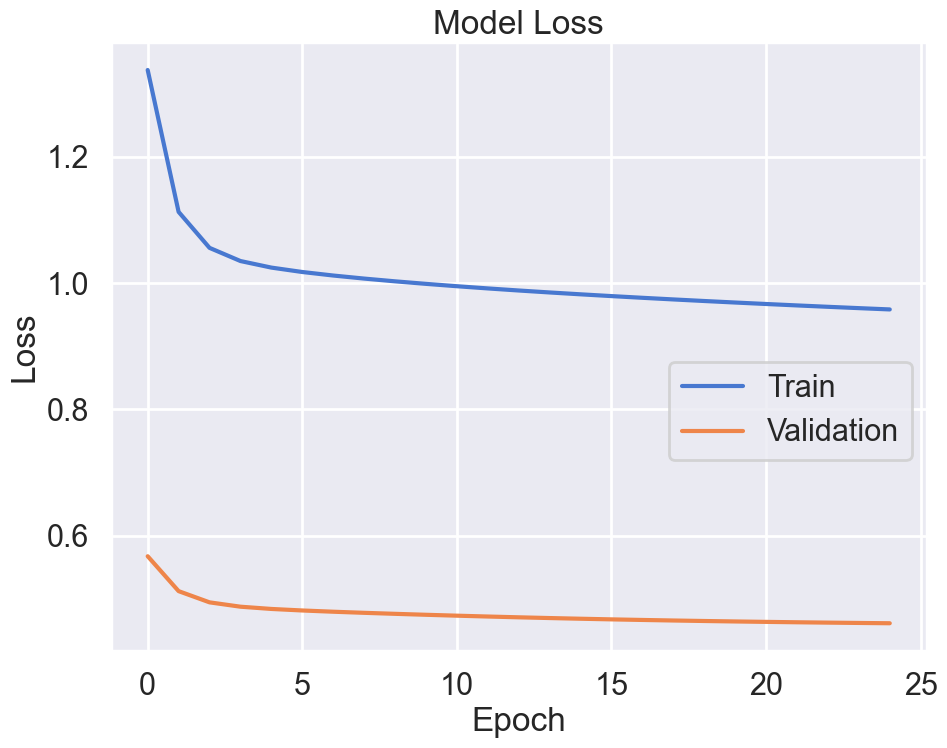

In [73]:
plot(history,'loss')

In [74]:
model_2_train_perf = model_performance_classification(model, X_train, y_train)
model_2_train_perf

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.769143,0.769143,0.833425,0.787335


In [75]:
model_2_valid_perf = model_performance_classification(model, X_val, y_val)
model_2_valid_perf

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.772667,0.772667,0.833418,0.790126


<div class="observation_text">Observations:</div>

- Training Loss:
    - Starts high (approx. 1.3) and drops quickly during the first few epochs but never fully stabilizes.
- Validation Loss:
    - Starts much lower (approx. 0.6) and drops quickly.
    - While the validation loss doesn’t fully stabilize, it is more stable than the training loss.
- The training loss did not saturate, whereas the validation loss was more stable, suggesting potential overfitting, an improper learning rate, or poor optimization.
- Next, We will increase the number of epoch and introduce a model with dropout to see if that improves performance and reduces loss. 

### Neural Network with Adam Optimizer and Dropout

In [77]:
epochs = 100
adam_optimizer = Adam(learning_rate=0.001)
model=create_model(v_optimizer=adam_optimizer,v_hidden_layer=[32], v_activation=['tanh'], drop_out=[0.2])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.adam.Adam object at 0x31f606740>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: tanh
------------------------------
Layer: dropout
------------------------------
Layer: dense_1
Activation: sigmoid


In [78]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], class_weight=cw_dict, shuffle=False)
end=time.time()

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2869 - recall: 0.6672 - val_loss: 0.5362 - val_recall: 0.7582
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1305 - recall: 0.7029 - val_loss: 0.5093 - val_recall: 0.7614
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0987 - recall: 0.7086 - val_loss: 0.4970 - val_recall: 0.7680
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0877 - recall: 0.7144 - val_loss: 0.4862 - val_recall: 0.7778
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0671 - recall: 0.7163 - val_loss: 0.4883 - val_recall: 0.7876
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0710 - recall: 0.7274 - val_loss: 0.4813 - val_recall: 0.7843
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0649 - recall: 0.7322 - val_loss: 0.4829 - val_recall: 0.7941
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0662 - recall: 0.7407 - val_loss: 0.4802 - val_recall: 0.7941

In [79]:
print("Time taken in seconds ",end-start)

Time taken in seconds  77.67922830581665


In [80]:
# Check the which epoch our model chose as the best available model
best_epoch = np.argmax(history.history['recall']) + 1  # Since epochs are 1-indexed
best_recall = max(history.history['recall'])
print(f"The best epoch was: {best_epoch} and best recall was: {best_recall}")

The best epoch was: 62 and best recall was: 0.7601683139801025


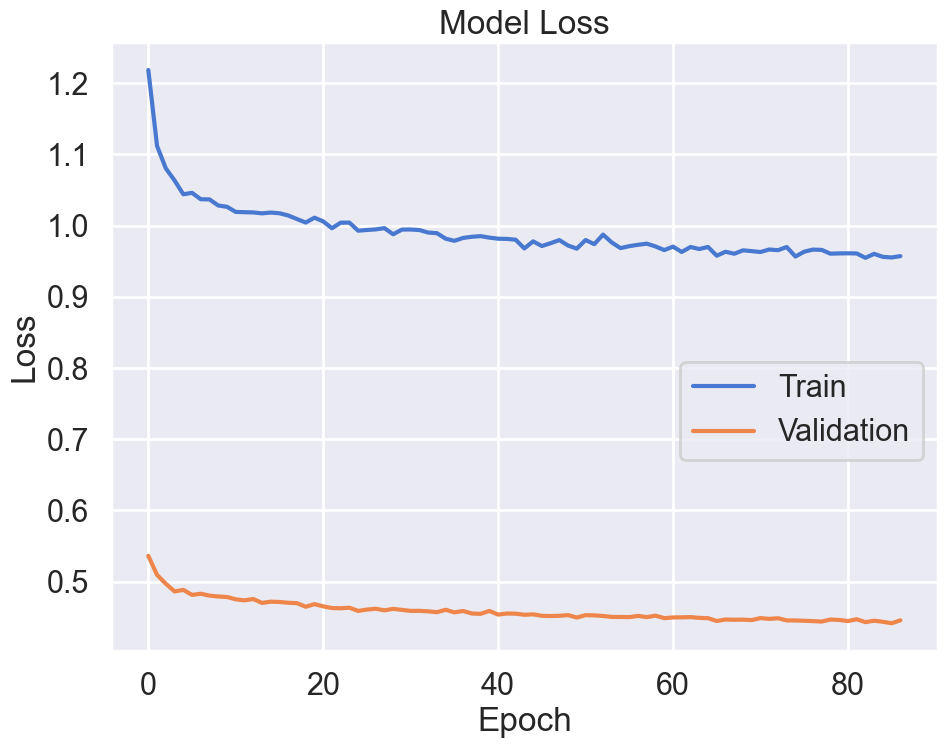

In [81]:
plot(history,'loss')

In [82]:
model_3_train_perf = model_performance_classification(model, X_train, y_train)
model_3_train_perf

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.779857,0.779857,0.834536,0.796011


In [83]:
model_3_valid_perf = model_performance_classification(model, X_val, y_val)
model_3_valid_perf

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.790667,0.790667,0.846499,0.806319


<div class="observation_text">Observations:</div>

- The training loss was decreasing, but after a few epochs, the validation loss stabilized. This suggests that the model was on the verge of overfitting. It’s good that our model selected epoch 20, where the validation loss was still decreasing. This indicates that the chosen epoch is effective for generalizing the data.
- The recall scores for both the training and validation sets are very close, indicating that the model is successfully generalizing the pattern.
- Next, We will use SMOTE to balance our imbalanced data by generating synthetic samples for the minority class. We will begin with the SGD optimizer.

### Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer

In [84]:
X_train_org, y_train_org = X_train, y_train
smote = SMOTE(random_state=rn)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [85]:
model=create_model(v_optimizer="sgd",v_hidden_layer=[32], v_activation=['tanh'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.sgd.SGD object at 0x31b63ec50>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: tanh
------------------------------
Layer: dense_1
Activation: sigmoid


In [86]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], shuffle=False)
end=time.time()

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5896 - recall: 0.3579 - val_loss: 0.7439 - val_recall: 0.9118
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6261 - recall: 0.6755 - val_loss: 0.7394 - val_recall: 0.9085
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6123 - recall: 0.7201 - val_loss: 0.7187 - val_recall: 0.8889
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5952 - recall: 0.7253 - val_loss: 0.7039 - val_recall: 0.8889
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5826 - recall: 0.7294 - val_loss: 0.6947 - val_recall: 0.8791
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5736 - recall: 0.7364 - val_loss: 0.6890 - val_recall: 0.8824
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5671 - recall: 0.7414 - val_loss: 0.6858 - val_recall: 0.8791
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5623 - recall: 0.7451 - val_loss: 0.6841 - val_recall: 0.8824


In [87]:
print("Time taken in seconds ",end-start)

Time taken in seconds  86.78894209861755


In [88]:
# Check the which epoch our model chose as the best available model
best_epoch = np.argmax(history.history['recall']) + 1  # Since epochs are 1-indexed
best_recall = max(history.history['recall'])
print(f"The best epoch was: {best_epoch} and best recall was: {best_recall}")

The best epoch was: 100 and best recall was: 0.7922497391700745


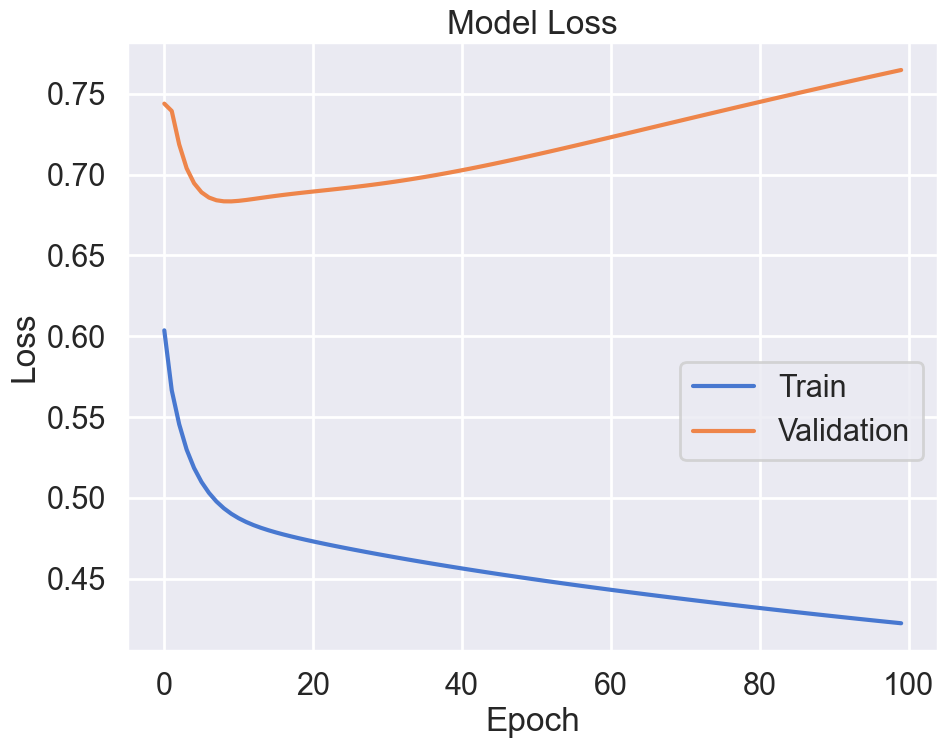

In [89]:
plot(history,'loss')

In [90]:
model_4_train_perf = model_performance_classification(model, X_train, y_train)
model_4_train_perf

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,Accuracy,Recall,Precision,F1 Score
0,0.715375,0.715375,0.766067,0.70114


In [91]:
model_4_valid_perf = model_performance_classification(model, X_val, y_val)
model_4_valid_perf

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.596,0.596,0.835038,0.630528


<div class="observation_text">Observations:</div>

- Training loss was decreasing, but after 40 epochs, the validation loss started increasing. Since epoch 99 was selected as the best epoch, we can clearly say our model is overfitting. This is further confirmed by the performance: the recall score on the training data is approximately 74.77%, while the recall on the validation data is much lower, around 66%.
- This overfitting could be due to the synthetic data we created, which might not correctly represent the data.
- To confirm this, next, we will use SMOTE again but with the Adam optimizer.

### Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer

In [95]:
model=create_model(v_optimizer=Adam(learning_rate=0.001),v_hidden_layer=[32], v_activation=['tanh'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.adam.Adam object at 0x31f0e1780>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: tanh
------------------------------
Layer: dense_1
Activation: sigmoid


In [96]:
#tf.config.run_functions_eagerly(True) 
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], shuffle=False)
end=time.time()

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.5535 - recall: 0.4735 - val_loss: 0.9774 - val_recall: 0.9248
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.6863 - recall: 0.7472 - val_loss: 0.8294 - val_recall: 0.8954
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.6275 - recall: 0.7332 - val_loss: 0.7892 - val_recall: 0.8987
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.6093 - recall: 0.7417 - val_loss: 0.7638 - val_recall: 0.8987
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.5983 - recall: 0.7425 - val_loss: 0.7433 - val_recall: 0.8987
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.5899 - recall: 0.7448 - val_loss: 0.7256 - val_recall: 0.8922
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.5827 - recall: 0.7485 - val_loss: 0.7101 - val_recall: 0.8889
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.5763 - recall: 0.7486 - val_loss: 0.6966 - val_recall:

In [97]:
print("Time taken in seconds ",end-start)

Time taken in seconds  495.07755303382874


In [98]:
# Check the which epoch our model chose as the best available model
best_epoch = np.argmax(history.history['recall']) + 1  # Since epochs are 1-indexed
best_recall = max(history.history['recall'])
print(f"The best epoch was: {best_epoch} and best recall was: {best_recall}")

The best epoch was: 99 and best recall was: 0.7883028388023376


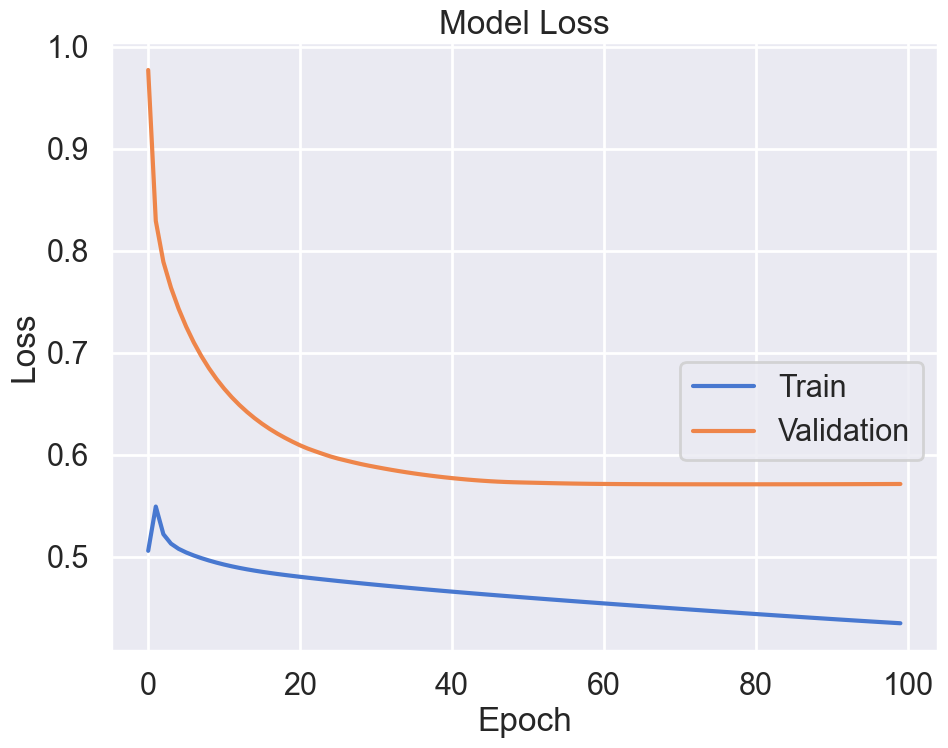

In [99]:
plot(history,'loss')

In [100]:
model_5_train_perf = model_performance_classification(model, X_train, y_train)
model_5_train_perf

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.787854,0.787854,0.798507,0.785945


In [101]:
model_5_valid_perf = model_performance_classification(model, X_val, y_val)
model_5_valid_perf

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.710667,0.710667,0.838486,0.738455


<div class="observation_text">Observations:</div>

- After 10 epochs, we can observe that the validation loss almost stabilized, while the training loss kept decreasing very slowly. This might indicate slight overfitting, but it is likely not significant.
- It also shows that the model is not learning much with more epochs. To improve performance, we can try using a regularization technique like dropout. Let’s see if this further improves the performance.

### Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout

In [102]:
model=create_model(v_optimizer=Adam(learning_rate=0.001),v_hidden_layer=[32], v_activation=['tanh'], drop_out=[0.2])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.adam.Adam object at 0x31f8cf070>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: tanh
------------------------------
Layer: dropout
------------------------------
Layer: dense_1
Activation: sigmoid


In [103]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], shuffle=False)
end=time.time()

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.5727 - recall: 0.4591 - val_loss: 0.8491 - val_recall: 0.9020
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.6726 - recall: 0.7270 - val_loss: 0.7522 - val_recall: 0.8856
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.6265 - recall: 0.7353 - val_loss: 0.7196 - val_recall: 0.8758
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.6077 - recall: 0.7377 - val_loss: 0.6984 - val_recall: 0.8791
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.5934 - recall: 0.7467 - val_loss: 0.6820 - val_recall: 0.8758
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.5828 - recall: 0.7537 - val_loss: 0.6682 - val_recall: 0.8693
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.5802 - recall: 0.7369 - val_loss: 0.6559 - val_recall: 0.8725
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.5715 - recall: 0.7516 - val_loss: 0.6436 - val_recall:

In [104]:
print("Time taken in seconds ",end-start)

Time taken in seconds  572.0599281787872


In [105]:
# Check the which epoch our model chose as the best available model
best_epoch = np.argmax(history.history['recall']) + 1  # Since epochs are 1-indexed
best_recall = max(history.history['recall'])
print(f"The best epoch was: {best_epoch} and best recall was: {best_recall}")

The best epoch was: 99 and best recall was: 0.770003616809845


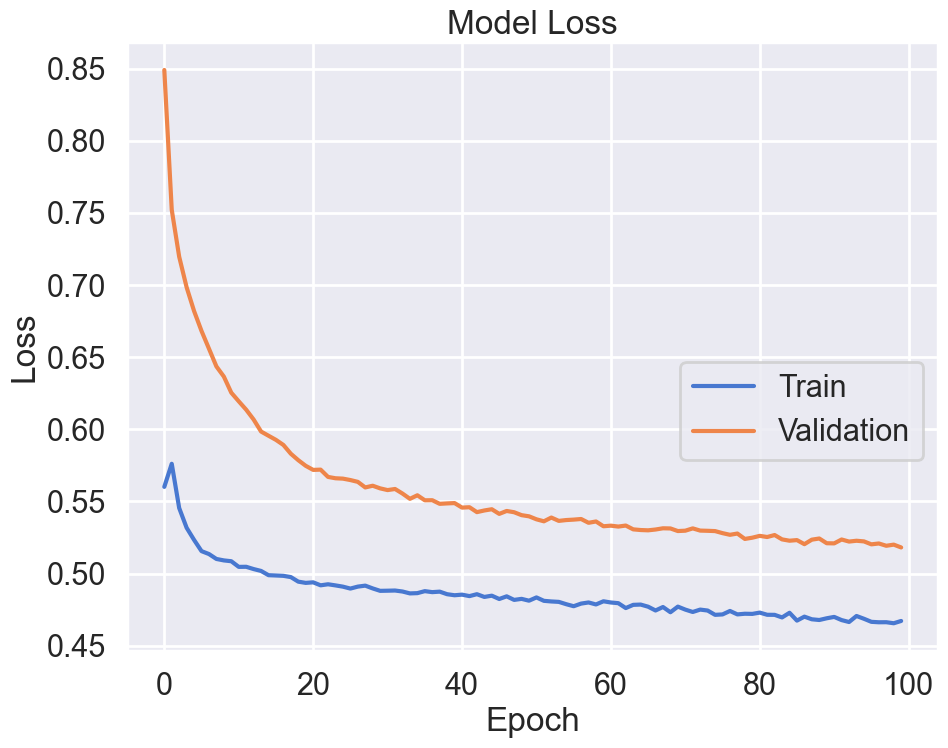

In [106]:
plot(history,'loss')

In [107]:
model_6_train_perf = model_performance_classification(model, X_train, y_train)
model_6_train_perf

349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.78301,0.78301,0.786684,0.782313


In [108]:
model_6_valid_perf = model_performance_classification(model, X_val, y_val)
model_6_valid_perf

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.749333,0.749333,0.843193,0.771969


<div class="observation_text">Observations:</div>

- From the loss and performance, we can observe that this model is very similar to our previous model without dropout.
- If we have to choose between the two, this one should be preferred, as the dropout makes it more likely to generalize better in the long run.
- Next, let’s evaluate all six models to determine which one performs best and should be chosen as our final model.

## Model Performance Comparison and Final Model Selection

In [109]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
        model_5_train_perf.T,
        model_6_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Neural Network (SGD, No Regularization)",
    "Neural Network (Adam , No Regularization)",
    "Neural Network (Adam, dropout [0.2])",
    "Neural Network (SGD, SMOTE, No Regularization)",
    "Neural Network (Adam, SMOTE, No Regularization)",
    "Neural Network (Adam, SMOTE, dropout [0.2])"
]

In [110]:
#Validation performance comparison

models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T,
        model_5_valid_perf.T,
        model_6_valid_perf.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Neural Network (SGD, No Regularization)",
    "Neural Network (Adam , No Regularization)",
    "Neural Network (Adam, dropout [0.2])",
    "Neural Network (SGD, SMOTE, No Regularization)",
    "Neural Network (Adam, SMOTE, No Regularization)",
    "Neural Network (Adam, SMOTE, dropout [0.2])"
]

In [111]:
models_train_comp_df

,"Neural Network (SGD, No Regularization)","Neural Network (Adam , No Regularization)","Neural Network (Adam, dropout [0.2])","Neural Network (SGD, SMOTE, No Regularization)","Neural Network (Adam, SMOTE, No Regularization)","Neural Network (Adam, SMOTE, dropout [0.2])"
Accuracy,0.747286,0.769143,0.779857,0.715375,0.787854,0.783010
Recall,0.747286,0.769143,0.779857,0.715375,0.787854,0.783010
Precision,0.821155,0.833425,0.834536,0.766067,0.798507,0.786684
F1 Score,0.768198,0.787335,0.796011,0.701140,0.785945,0.782313


In [112]:
models_valid_comp_df

,"Neural Network (SGD, No Regularization)","Neural Network (Adam , No Regularization)","Neural Network (Adam, dropout [0.2])","Neural Network (SGD, SMOTE, No Regularization)","Neural Network (Adam, SMOTE, No Regularization)","Neural Network (Adam, SMOTE, dropout [0.2])"
Accuracy,0.760667,0.772667,0.790667,0.596000,0.710667,0.749333
Recall,0.760667,0.772667,0.790667,0.596000,0.710667,0.749333
Precision,0.838070,0.833418,0.846499,0.835038,0.838486,0.843193
F1 Score,0.780966,0.790126,0.806319,0.630528,0.738455,0.771969


<div class="observation_text">Observations:</div>

- We can clearly see that the third model, with the Adam optimizer and 20% dropout, is performing the best. It generalizes well and effectively reduces False Negatives, which aligns with our goal.
- Therefore, we will choose this model as our final model.

<div class="custom_header1">Final Model</div>

In [113]:
X_train, y_train = X_train_org, y_train_org
model=create_model(v_optimizer=Adam(learning_rate=0.001),v_hidden_layer=[32], v_activation=['tanh'], drop_out=[0.2])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------
MODEL INFO:
******************************
Model optimizer: <keras.src.optimizers.adam.Adam object at 0x31f74f190>
Loss function: binary_crossentropy
------------------------------
Layer: dense
Activation: tanh
------------------------------
Layer: dropout
------------------------------
Layer: dense_1
Activation: sigmoid


In [114]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, callbacks=[early_stopping], shuffle=False)
end=time.time()

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.7504 - recall: 0.6192 - val_loss: 0.4477 - val_recall: 0.0915
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.4588 - recall: 0.1066 - val_loss: 0.4051 - val_recall: 0.1536
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.4298 - recall: 0.1909 - val_loss: 0.3827 - val_recall: 0.2614
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.4153 - recall: 0.2602 - val_loss: 0.3695 - val_recall: 0.3170
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.4021 - recall: 0.3003 - val_loss: 0.3617 - val_recall: 0.3529
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.3983 - recall: 0.3437 - val_loss: 0.3574 - val_recall: 0.3660
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.3905 - recall: 0.3462 - val_loss: 0.3538 - val_recall: 0.3922
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.3893 - recall: 0.3808 - val_loss: 0.3517 - val_recall:

<div class="custom_header2">Train Data Performance on Final Model</div>

In [115]:
model_performance_classification(model, X_train, y_train)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.858143,0.858143,0.848932,0.842628


<div class="custom_header2">Validation Data Performance on Final Model</div>

In [116]:
model_performance_classification(model, X_val, y_val)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.870667,0.870667,0.863781,0.85881


<div class="custom_header2">Test Data Performance on Final Model</div>

In [117]:
model_performance_classification(model, X_test, y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Recall,Precision,F1 Score
0,0.866,0.866,0.858333,0.85265


<div class="observation_text">Observations:</div>

- We can observe that our final model is generalizing well on unseen data. The accuracy, recall, and precision across the training, validation, and testing datasets are very close.
- We are happy to deliver this model to the bank. However, in the future, we would like to make a few more changes to improve its performance.

<div class="custom_header2">Future Changes For the Model:</div>

- We can use hyperparameter tuning to find the best parameters and build a model using those parameters, which are most likely to improve the performance of the model.
- Additionally, we can explore other methods to balance the imbalanced data and check if they help improve performance.
- We can also consider adding batch normalization, which might further boost the model’s performance.

## Actionable Insights and Business Recommendations

1. The bank can deploy our model to identify customers who are most likely to churn and offer them extra incentives to encourage them to reconsider their decision.
2. The bank should instruct its employees not to offer or grant more than two products unless absolutely necessary. For customers who have only one product, employees can encourage them to get an additional product, as the customers with 2 products are least likely to churn.
3. If we can gather more information about the Germany branch, we may be able to predict why customer churn is highest there. If not, the bank can visit the branch to identify the root cause of the issue and work on resolving it.
4. The same applies to female customers. We need to understand why they are leaving more than male customers. Consider offering gender-specific personalized offers or providing assistance to make them feel valued and heard.
5. Plan to offer special retirement rates for older customers to retain them.
6. Customers in their first two years are slightly more likely to churn, so the bank should give special attention during this period to make customers feel valued and reduce churn.
7. Account balance has a slight influence on churn. Customers with higher balances are a little less likely to churn, so the bank can offer special rates to encourage people to save more, which might help reduce churn.
8. Having a credit card or not does not, on its own, influence churn. Currently, 29.4% of customers do not have a credit card. The bank should consider offering credit cards more frequently, as this could generate more income without increasing churn.

<font size=6 color='blue'>Power Ahead</font>
___